In [27]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure

import random
import copy
import math
import os

In [62]:
# # CSV to PGM

# lines = 0
# with open('maps/semantics/master_big/humandensityvel-master_big-test.csv') as f:
#     lines = f.readlines()

# h = len(lines)
# w = len(lines[0].split(','))

# count = 0
# data = []
# map = []
# map.extend(['P2'])
# map.extend([f'{w}, {h}'])
# map.extend([f'255'])
# # Converts data to a list of integers
# for line in lines:
#     map.extend([int(float(c)*255) for c in line.split(',')])

# np.savetxt("maps/semantics/master_big/humandensityvel-master_big-test.pgm",map,fmt='%s')

In [29]:
# # PGM to CSV

# direc = 'maps/semantics/willow/'
# file_list = os.listdir(direc)
# i = 0
# while i < len(file_list):
#     if not ".pgm" in file_list[i]:
#         file_list.remove(file_list[i])
#         i = i-1
#     i = i+1

# for file in file_list:
#     lines = 0
#     print(direc+file)
#     with open(direc+file) as f:
#         lines = f.readlines()

#     sizes = lines[2].split(' ')
#     h = int(sizes[1])
#     w = int(sizes[0])

#     map = np.zeros((h,w))

#     count = 0
#     # Converts data to a list of integers
#     for line in lines[3:-1]:
#         map[int(count/w),count%w] = int(line)
#         # map[int(count/w),count%w] = int(int(line)>254)*255
#         count = count +1

#     df = pd.DataFrame(map)
#     df = df.astype(int)
#     output_file = list(direc+file)
#     output_file[-3:] = 'csv'
#     output_file = ''.join(output_file)
#     df.to_csv(output_file,header=None, index=None)

master_big


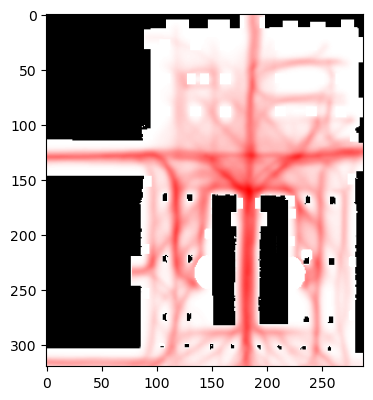

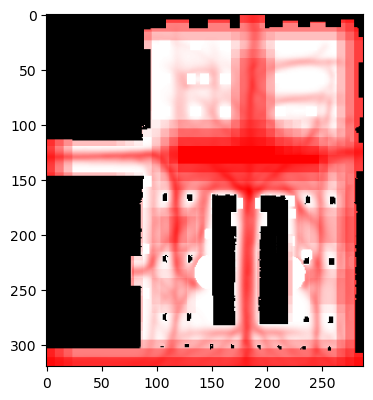

willow


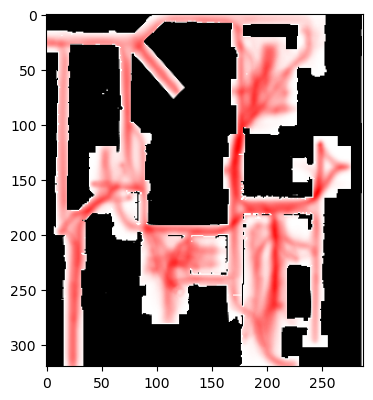

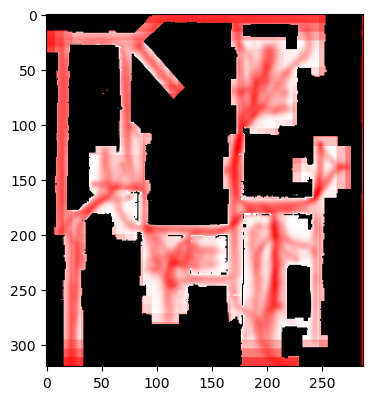

costacafe


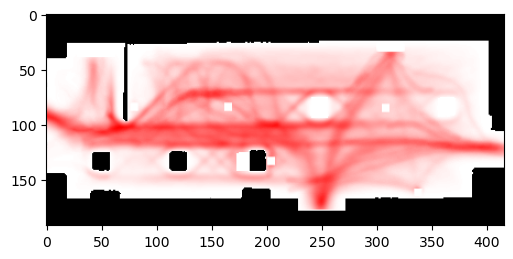

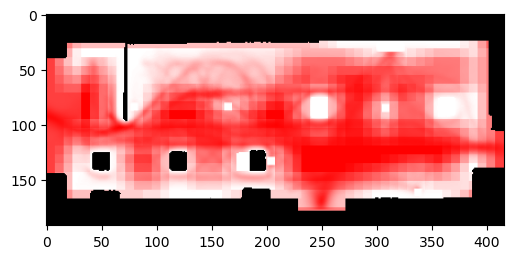

map1


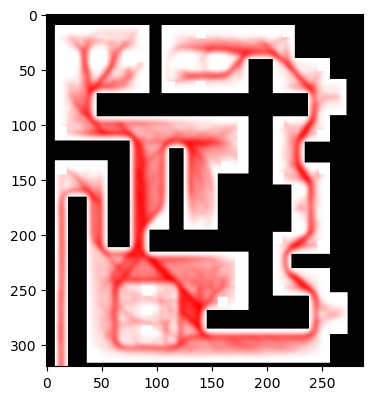

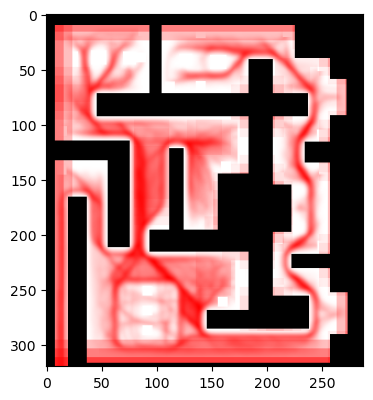

map2


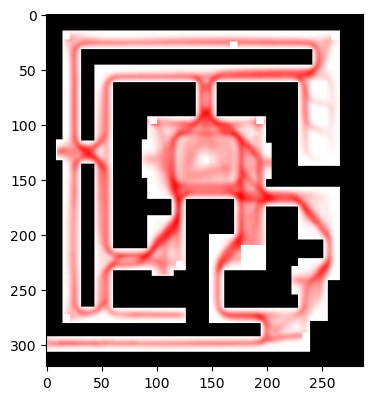

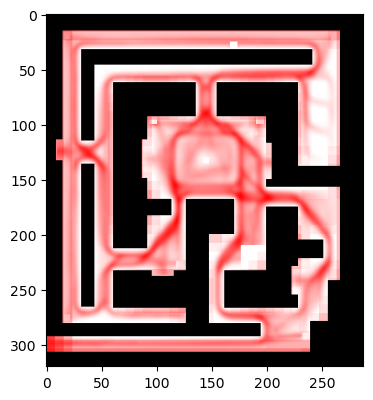

map3


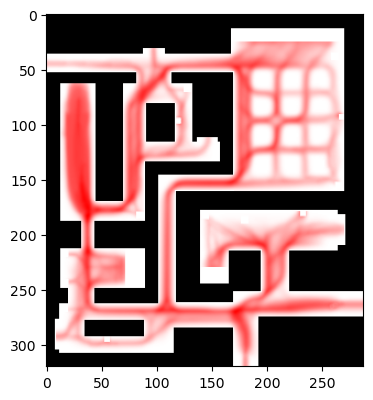

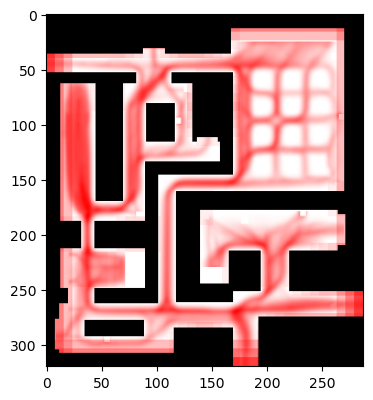

In [30]:
div = 32
step = int(32/4)

sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']
chans = len(sem_dict)+1

train_x = np.zeros((1, 32, 32, chans))
train_y = np.zeros((1, 32, 32))

map_list = ['master_big','willow','costacafe','map1','map2','map3']

# -----------------------------------------------------------------------------------
for map_name in map_list:
  print(map_name)

  lines = 0
  with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
      lines = f.readlines()

    hh = len(lines)
    ww = len(lines[0].split(','))

    if hh != h or ww != w:
      print(f'h: {h}\tw: {w}')
      print(f'h: {hh}\tw: {ww}')
      raise SystemExit("ERROR: Different sizes!!")

    # Converts data to a list of integers
    for line in lines:
      map.extend([int(c) for c in line.split(',')])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/2)),int(math.ceil(w/2)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (2,2), np.max)
  h, w, _ = map.shape

  diff_h = int((h-div*int(h/div))/2)
  r_h = int((h-div*int(h/div))%2) + diff_h
  diff_w = int((w-div*int(w/div))/2)
  r_w = int((w-div*int(w/div))%2) + diff_w
  map = map[r_h:-diff_h:,r_w+diff_w:,:]

  # print(map.shape)
  h, w, _ = map.shape

  # -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'5.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  data = skimage.measure.block_reduce(data, (2,2), np.max)
  data = data[r_h:-diff_h,r_w+diff_w:]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))

  # print(data.shape)
  hd, wd = data.shape

  # inverted_map = np.add(map, np.full((h, w), -1))*255
  # out = np.clip(np.add(data, inverted_map),0,255)

  fig = plt.figure(figsize=(w/70,h/70))
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),data,data),axis=2)), vmin=0, vmax=1)
  plt.show()

  # -----------------------------------------------------------------------------------
  fig = plt.figure(figsize=(w/70,h/70))
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  num = 0
  start = train_x.shape[0] - 1
  for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
    c = int(i%(w/step+int(div/step-1))) - int(div/step-1)
    r = int(i/(w/step+int(div/step-1))) - int(div/step-1)
    submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
    subdata = data[max(step*r,0):step*r+div, max(step*c,0):step*c+div]
    if np.mean(submap[:,:,0]) > 0.2 and np.mean(submap[:,:,:]) < 1 and submap.shape == (32, 32, chans):
      num = num + 1
      data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
      train_x = np.append(train_x, np.expand_dims(submap, axis=0), axis=0)
      train_y = np.append(train_y, np.expand_dims(subdata, axis=0), axis=0)

  for j in np.arange(3):
    for i in np.arange(num)+start:
      train_x = np.append(train_x, np.expand_dims(np.rot90(train_x[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
      train_y = np.append(train_y, np.expand_dims(np.rot90(train_y[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)

  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),data_pred,data_pred),axis=2)), vmin=0, vmax=1)
  plt.show()

train_x = np.delete(train_x, 0, 0)
train_y = np.delete(train_y, 0, 0)

In [31]:
num_validation = 10  #int(num * 0.1)

original_data_x = train_x
original_data_y = train_y

In [32]:
train_x = original_data_x
train_y = original_data_y

p = np.random.permutation(len(train_x))
train_x = train_x[p]
train_y = train_y[p]

num = train_x.shape[0]
num_test = int(num * 0.1)
num_train = num - num_test - num_validation

validation_x = train_x[:num_validation,:,:]
validation_y = train_y[:num_validation,:,:]

train_x = train_x[num_validation:,:,:]
train_y = train_y[num_validation:,:,:]

test_x = train_x[:num_test,:,:]
test_y = train_y[:num_test,:,:]

train_x = train_x[num_test:,:,:]
train_y = train_y[num_test:,:,:]

print(train_x.shape)
print(test_x.shape)
print(validation_x.shape)

(20474, 32, 32, 8)
(2276, 32, 32, 8)
(10, 32, 32, 8)


13854
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']


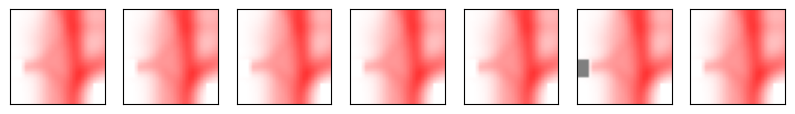

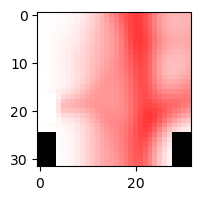

In [42]:
i = int(random.random()*train_x.shape[0])
# i = 6359
print(i)
c = int(i%(w/step))
r = int(i/(w/step))
submap = train_x[i,:,:]
subdata = train_y[i,:,:]

print(sem_dict)
plt.figure(figsize=(10,5))
for i in range(len(sem_dict)):
    i = i+1
    ax = plt.subplot(1, len(sem_dict), i)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((submap[:,:,i],submap[:,:,i],submap[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(subdata.shape,1),subdata,subdata),axis=2)), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig = plt.figure(figsize=(2,2))
plt.imshow(np.multiply(np.stack((submap[:,:,0],submap[:,:,0],submap[:,:,0]),axis=2), np.stack((np.full(subdata.shape,1),subdata,subdata),axis=2)), vmin=0, vmax=1)
plt.show()

In [ ]:
# (train_x, _), (test_x, _) = tf.keras.datasets.cifar10.load_data()
# train_x = train_x/255
# test_x = test_x/255

# train_x = train_x[:,:,:,0]*0.2989 + train_x[:,:,:,1]*0.5870 + train_x[:,:,:,2]*0.1140
# test_x = test_x[:,:,:,0]*0.2989 + test_x[:,:,:,1]*0.5870 + test_x[:,:,:,2]*0.1140
# # train_x = np.stack((train_x,train_x,train_x), axis=3)
# # test_x = np.stack((test_x,test_x,test_x), axis=3)

# validation_x = train_x[:num_validation,:,:]
# train_x = train_x[num_validation:,:,:]

# train_y = train_x
# test_y = test_x
# validation_y = validation_x

# print(train_x.shape)
# print(test_x.shape)
# print(validation_x.shape)

In [43]:
# CNN-11  |  CNN-21  |  CNN-31
fil_array = [4,8,8]                         #Num filters first conv: 4, 8 or 8
lay_array = [1,3,5]                         #Layers per dense block: 1, 3 or 5
learn_array = [8.71e-5,3.72e-4,1.51e-4]     #Learning rates
decaylearn_array = [0.9984,0.9984,0.9985]   #Learning rate decays
wdecay_array = [1.11e-6,5.53e-7,4.58e-5]    #Weight decays
dropout_array = [0.307,0.120,0.349]         #Dropout probability

arc = 2                                     #[0,1,2]

filters = fil_array[arc]        
layers_in_dense = lay_array[arc]

tf.random.set_seed(0)
dropout_array[arc] = dropout_array[arc] * 0.01

def dense_factor(inputs):
    h_1 = layers.BatchNormalization()(inputs)
    output = layers.Conv2D(32, (3,3), padding='same', activation='relu')(h_1)
    return output

def dense_block(inputs, upsampling):
    concatenated_inputs = inputs
    concatenated_inputs_less = []
    for i in range(layers_in_dense):
        x = dense_factor(concatenated_inputs)
        concatenated_inputs = layers.concatenate([concatenated_inputs, x], axis=3)
        concatenated_inputs_less = layers.concatenate([concatenated_inputs, x], axis=3)
        if(i == layers_in_dense - 1 and upsampling):
            concatenated_inputs = concatenated_inputs_less

    return concatenated_inputs

input_img = layers.Input(shape=(div, div, chans))
lays = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(input_img)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters+2
lays = dense_block(lays,False)
lays = layers.Dropout(dropout_array[arc])(lays)
layerX = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters+1
lays = layers.MaxPooling2D((2, 2), strides=2)(layerX)
lays = dense_block(lays,False)
lays = layers.Dropout(dropout_array[arc])(lays)
layerY = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.MaxPooling2D((2, 2), strides=2)(layerY)

lays = dense_block(lays,True)

lays = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.Add()([layerY,lays])
lays = dense_block(lays,True)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters-1
lays = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.Add()([layerX,lays])
lays = dense_block(lays,False)
lays = layers.Dropout(dropout_array[arc])(lays)
filters = filters-2
lays = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)
lays = layers.Dense(units=2, activation='softmax')(lays)
lays = layers.Dropout(dropout_array[arc])(lays)

model = models.Model(input_img, lays)

# model.summary()

In [44]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=learn_array[arc],
                    decay_steps=10,
                    decay_rate=decaylearn_array[arc])

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule,weight_decay=wdecay_array[arc])
lr_metric = get_lr_metric(opt)

model.compile(
    optimizer=opt,
    # Loss function to minimize
    loss='binary_crossentropy',
    # List of metrics to monitor
    metrics=['mean_squared_error'],
) 

In [45]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15),
    # tf.keras.callbacks.ModelCheckpoint(filepath='IRI_models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
    x=train_x,
    y=np.stack((1-train_y,train_y),axis=3),
    batch_size=50,
    epochs=100, #100
    validation_data=(test_x, np.stack((1-test_y,test_y),axis=3)),
    callbacks=my_callbacks,
)

Epoch 1/100


2023-07-24 17:09:56.135639: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


410/410 [==============================] - 95s 219ms/step - loss: 0.3882 - mean_squared_error: 0.0311 - val_loss: 0.3529 - val_mean_squared_error: 0.0271
Epoch 2/100
410/410 [==============================] - 87s 213ms/step - loss: 0.3668 - mean_squared_error: 0.0240 - val_loss: 0.3385 - val_mean_squared_error: 0.0221
Epoch 3/100
410/410 [==============================] - 87s 213ms/step - loss: 0.3621 - mean_squared_error: 0.0225 - val_loss: 0.3356 - val_mean_squared_error: 0.0214
Epoch 4/100
410/410 [==============================] - 86s 210ms/step - loss: 0.3591 - mean_squared_error: 0.0216 - val_loss: 0.3339 - val_mean_squared_error: 0.0207
Epoch 5/100
410/410 [==============================] - 86s 210ms/step - loss: 0.3567 - mean_squared_error: 0.0208 - val_loss: 0.3350 - val_mean_squared_error: 0.0212
Epoch 6/100
410/410 [==============================] - 85s 207ms/step - loss: 0.3550 - mean_squared_error: 0.0201 - val_loss: 0.3340 - val_mean_squared_error: 0.0215
Epoch 7/100
410/

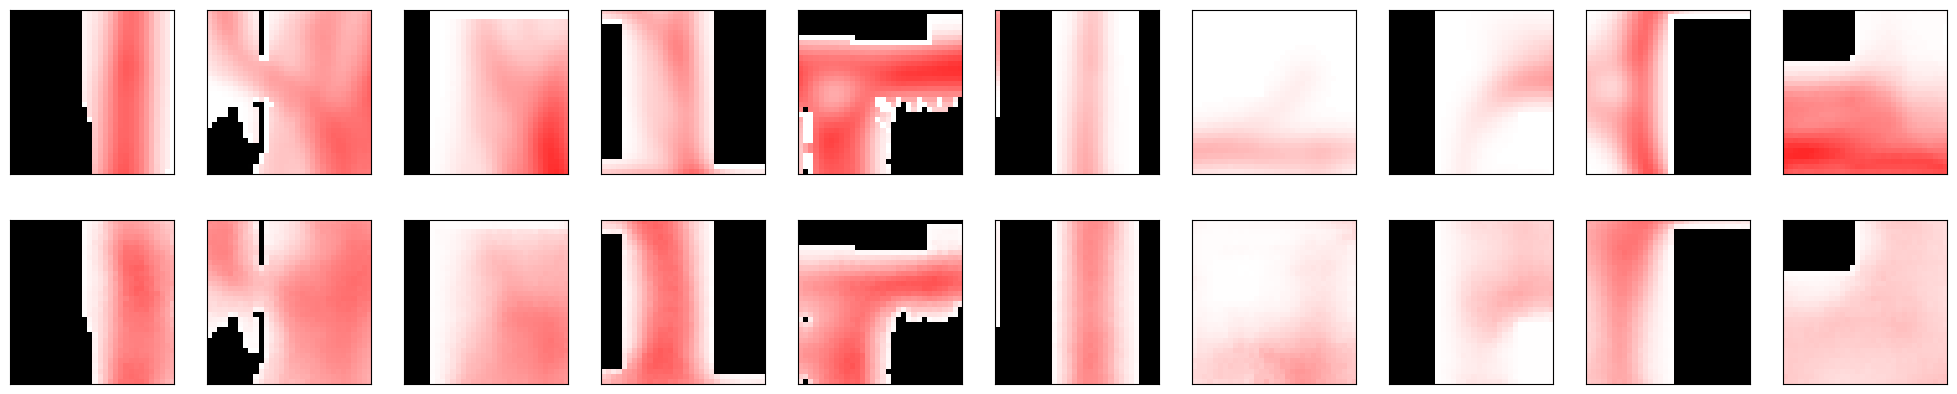

In [50]:
aux_x = validation_x
aux_y = validation_y

output = model.predict(aux_x,verbose=0)[:,:,:,1]

n = num_validation  # How many images we will display
plt.figure(figsize=(25, 5))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(aux_y[i].shape,1),aux_y[i],aux_y[i]),axis=2)), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.multiply(np.stack((aux_x[i,:,:,0],aux_x[i,:,:,0],aux_x[i,:,:,0]),axis=2), np.stack((np.full(output[i].shape,1),output[i],output[i]),axis=2)), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# Display original
plt.show()

1/1 - 0s - loss: 0.3470 - mean_squared_error: 0.0190 - 113ms/epoch - 113ms/step


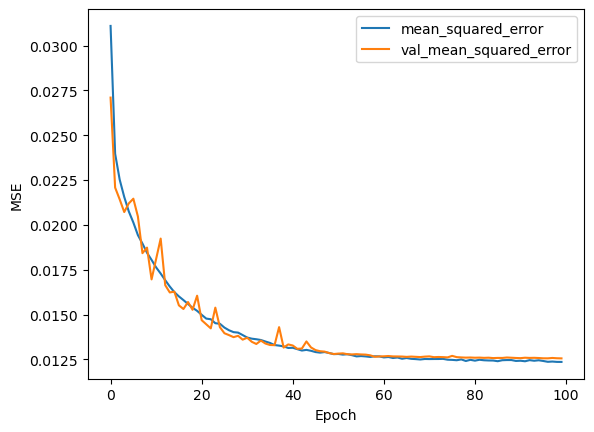

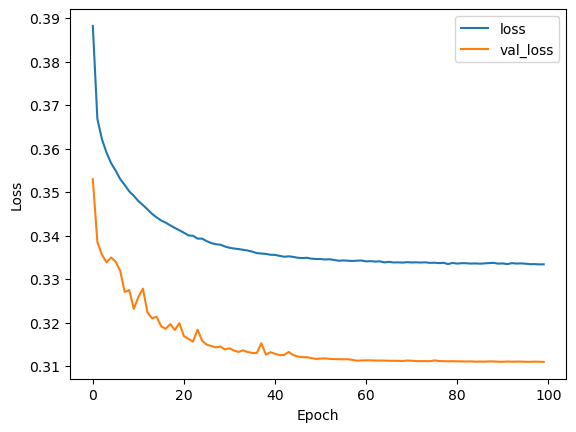

In [51]:
test_loss, test_acc = model.evaluate(aux_x,  np.stack((1-aux_y,aux_y),axis=3), verbose=2)

plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

master_big
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']


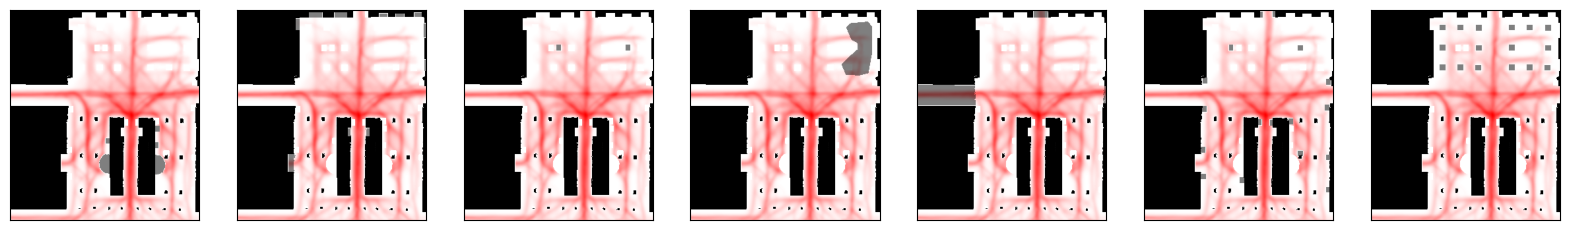

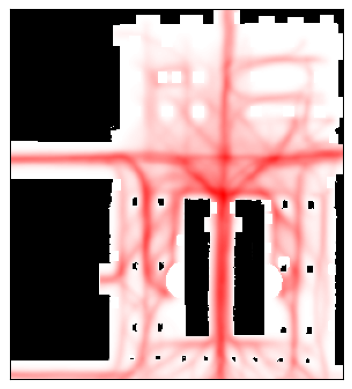

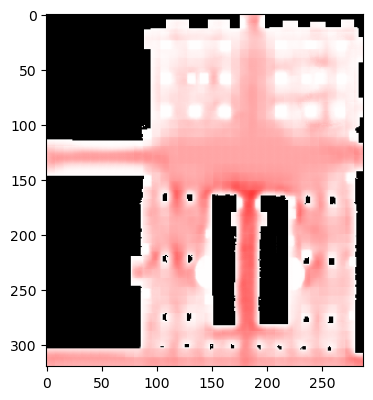

willow
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']


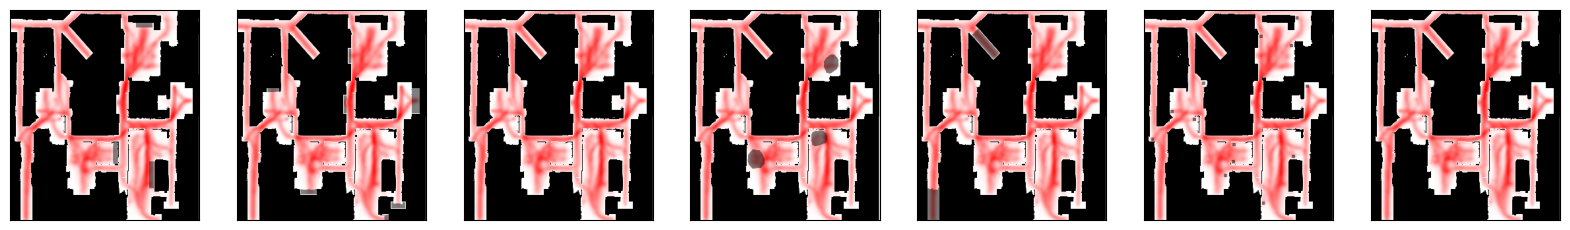

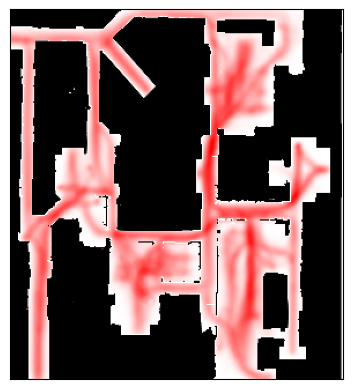

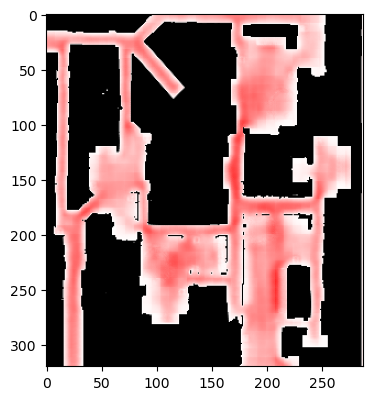

costacafe
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']


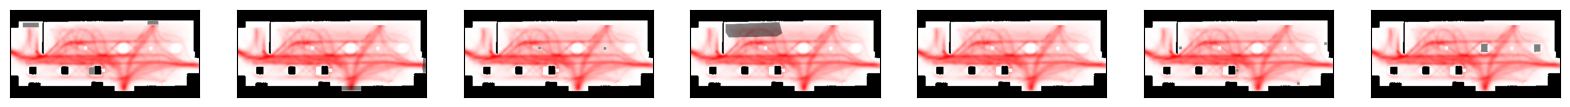

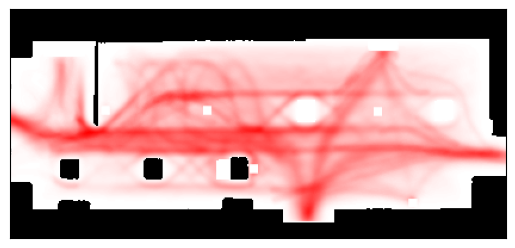

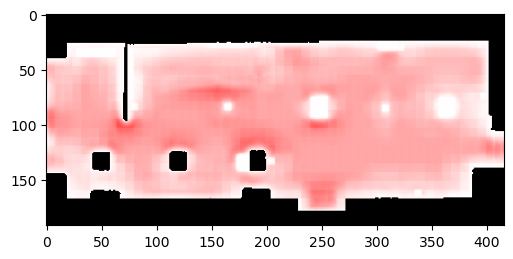

map1
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']


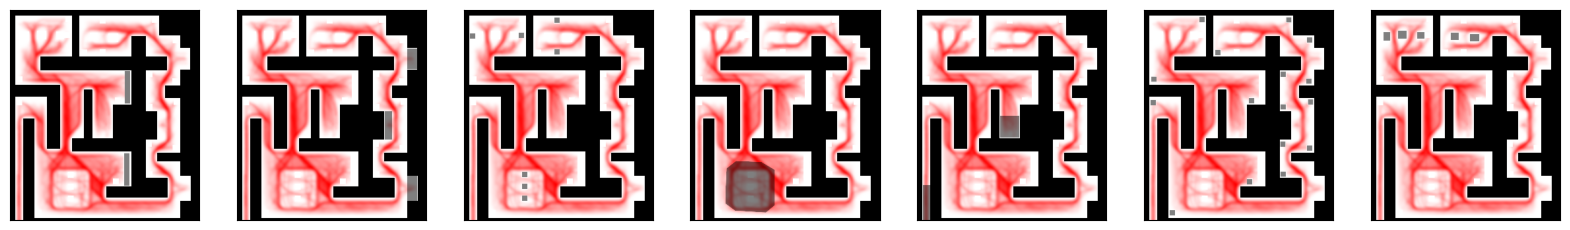

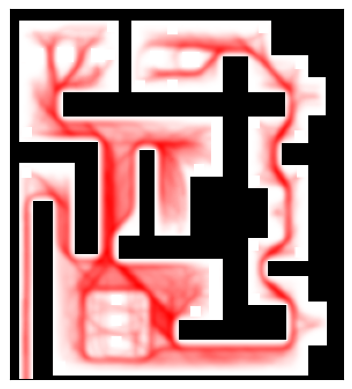

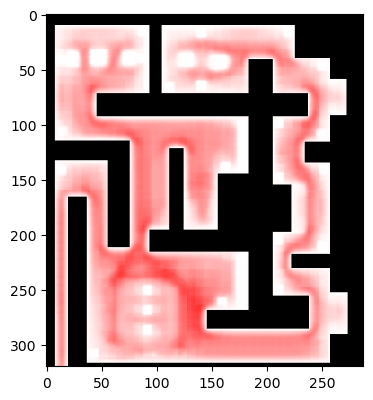

map2
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']


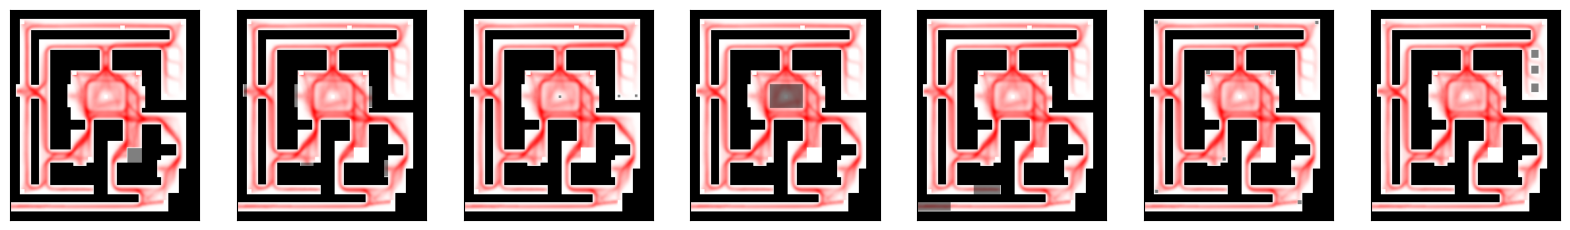

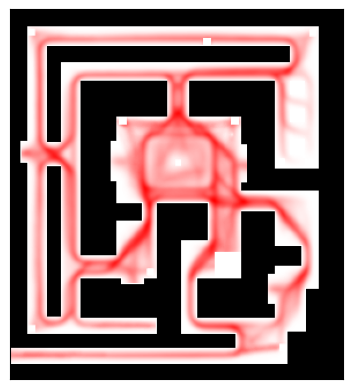

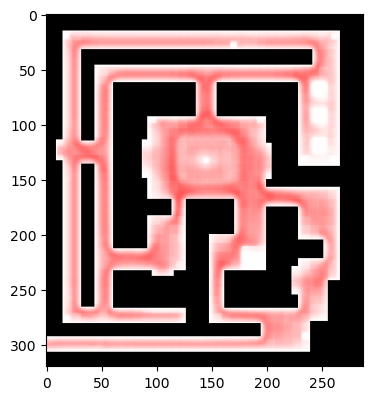

map3
['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree']


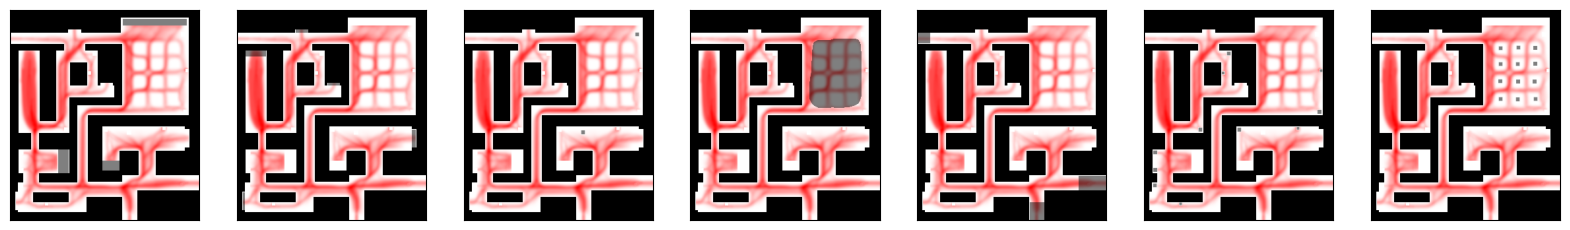

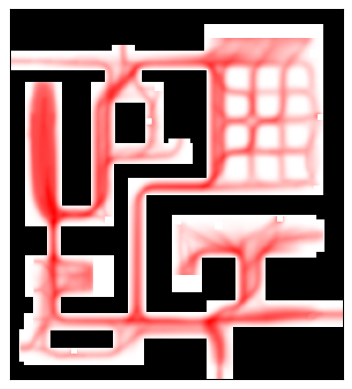

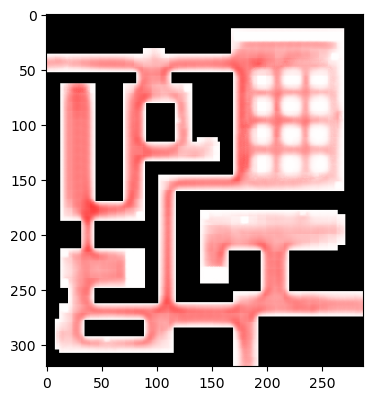

In [48]:
map_list = ['master_big','willow','costacafe','map1','map2','map3'] #'master_big','willow','costacafe','map1','map2','map3'

for map_name in map_list:
  print(map_name)

  lines = 0
  with open('maps/semantics/'+map_name+'/'+map_name+'.csv') as f:
    lines = f.readlines()

  h = len(lines)
  w = len(lines[0].split(','))

  # Converts data to a list of integers
  map = []
  for line in lines:
    map.extend([int(c) for c in line.split(',')])

  for lab_class in sem_dict:
    lines = 0
    with open('maps/semantics/'+map_name+'/'+map_name+'_sem_'+lab_class+'.csv') as f:
      lines = f.readlines()

    hh = len(lines)
    ww = len(lines[0].split(','))

    if hh != h or ww != w:
      print(f'h: {h}\tw: {w}')
      print(f'h: {hh}\tw: {ww}')
      raise SystemExit("ERROR: Different sizes!!")

    # Converts data to a list of integers
    for line in lines:
      map.extend([int(c) for c in line.split(',')])

  map = np.reshape(map,[chans,h,w])
  map = np.moveaxis(map, 0, -1)
  map = map/255

  map_aux = map
  map = np.zeros((int(math.ceil(h/2)),int(math.ceil(w/2)),chans))

  for idx in range(chans):
    map[:,:,idx] = skimage.measure.block_reduce(map_aux[:,:,idx], (2,2), np.max)
  h, w, _ = map.shape

  diff_h = int((h-div*int(h/div))/2)
  r_h = int((h-div*int(h/div))%2) + diff_h
  diff_w = int((w-div*int(w/div))/2)
  r_w = int((w-div*int(w/div))%2) + diff_w
  map = map[r_h:-diff_h:,r_w+diff_w:,:]

  # print(map.shape)
  h, w, _ = map.shape

# -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'5.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([int(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  data = skimage.measure.block_reduce(data, (2,2), np.max)
  data = data[r_h:-diff_h,r_w+diff_w:]
  data = np.subtract(data, np.full((h, w), np.min(data)))/(np.max(data)-np.min(data))*255
  data = data/255

  # print(data.shape)
  hd, wd = data.shape

  # inverted_map = np.add(map, np.full((h, w), -1))*255
  # out = np.clip(np.add(data, inverted_map),0,255)

  print(sem_dict)
  plt.figure(figsize=(20,5))
  for i in range(len(sem_dict)):
    i = i+1
    ax = plt.subplot(1, len(sem_dict), i)
    alp = 0.5
    ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2),np.multiply(np.stack((map[:,:,i],map[:,:,i],map[:,:,i]),axis=2)*alp+(1-alp), np.stack((np.full(data.shape,1),data,data),axis=2))), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

  ax = plt.subplot(111)
  ax.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data.shape,1),data,data),axis=2)), vmin=0, vmax=1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.show()

  # -----------------------------------------------------------------------------------
  # creating subplot and figure
  fig = plt.figure(figsize=(w/70,h/70))
  data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

  step = int(32/4)
  start = train_x.shape[0] - 1
  for i in np.arange((w/step+int(div/step-1))*(h/step+int(div/step-1))):
    c = int(i%(w/step+int(div/step-1))) - int(div/step-1)
    r = int(i/(w/step+int(div/step-1))) - int(div/step-1)
    submap = map[max(step*r,0):step*r+div, max(step*c,0):step*c+div,:]
    subdata = model.predict(np.expand_dims(submap,axis=0),verbose=0)[:,:,:,1]
    subdata = np.squeeze(subdata,axis=0)
    data_pred[max(step*r,0):step*r+div, max(step*c,0):step*c+div] += subdata*1/(int(div/step)*int(div/step))
  plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred.shape,1),data_pred,data_pred),axis=2)), vmin=0, vmax=1)
  plt.show()

In [49]:
# model.save('IRI_models/24july_8px_steps')
# model = tf.keras.models.load_model('IRI_models/21july_8px_steps')

INFO:tensorflow:Assets written to: IRI_models/24july_8px_steps/assets


INFO:tensorflow:Assets written to: IRI_models/24july_8px_steps/assets


Add benches, tables & chairs
Add also velocity information (two different maps for velocities and regions of stop)
Add heading of motion (directional velocity)
MAYBE Time of the day

mobility: main cues they are looking for (narrow places, which other criterias?) "Criterium" what do we need to look for
(from computer vision)

80% of time people pass stair and not sit
white noise velocity 

collect data with following robot/static robot